In [1]:
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *

setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

# Model 2: SSH input only

# Prepare training data for normalization statistics (SSH only)
x_train_ssh_only = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_normalized_ssh, min_vals_ssh, max_vals_ssh = min_max_normalize(x_train_ssh_only)

# Prepare test data (SSH only)
x_test_ssh_only_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_normalized_ssh, _, _ = min_max_normalize(x_test_ssh_only_original, min_vals_ssh, max_vals_ssh)

# Create test dataset and loader
test_dataset_ssh = TensorDataset(x_test_normalized_ssh, y_test)
test_loader_ssh = DataLoader(test_dataset_ssh, batch_size=32, shuffle=False)

# Load model
model_ssh_only = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model_ssh_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/ssh_input_only.pth', map_location=device)
model_ssh_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_ssh_only.eval()
results_ssh_only = {
    'ssh': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices_ssh = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_ssh):
        
        batch_start = i * test_loader_ssh.batch_size
        batch_end = min(batch_start + test_loader_ssh.batch_size, len(test_dataset_ssh))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_ssh.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_ssh_only(batch_x)
        
        ssh_batch_original = x_test_ssh_only_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_ssh_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_ssh_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_ssh_only['bm_true'].append(bm_true.cpu().numpy())
        results_ssh_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_ssh_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_ssh_only['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_ssh_only['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_ssh_only:
    results_ssh_only[key] = np.concatenate(results_ssh_only[key], axis=0)

print("Model 2 evaluation complete!")

# Model 3: MSE loss only
model_mse_only = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_mse_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/mse_loss_only.pth', map_location=device)
model_mse_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_mse_only.eval()
results_mse_only = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': []
}

sample_indices_mse = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):  
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_mse.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_mse_only(batch_x)
        
        # Use original scale SSH and SST for BM calculation
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # For MSE model, only use mean prediction (no sampling)
        mu_zca_expanded = outputs[:, 0:1, ...]  # Use first channel as mean
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Store results
        results_mse_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_mse_only['sst'].append(sst_batch_original.cpu().numpy())
        results_mse_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_mse_only['bm_true'].append(bm_true.cpu().numpy())
        results_mse_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_mse_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())

for key in results_mse_only:
    results_mse_only[key] = np.concatenate(results_mse_only[key], axis=0)

print("Model 3 evaluation complete!")

# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    ('ssh_only', results_ssh_only, True, False), 
    ('mse_only', results_mse_only, False, True)
]


Using device: cpu
Model 1 evaluation complete!
Model 2 evaluation complete!
Model 3 evaluation complete!


In [3]:

# Store all datasets
eval_datasets = {}

for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst, stochastic_samples=30)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset


Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for ssh_only...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for mse_only...


In [4]:
for k in eval_datasets.keys(): 
    #eval_datasets[k] = eval_datasets[k].chunk(chunks={'sample' : 100, 'stochastic_sample':100}) 
    eval_datasets[k] = eval_datasets[k].assign_coords(i = eval_datasets[k].i *1.5, j = eval_datasets[k].j *1.5)

In [5]:
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx  = np.where(clean_mask)[0]

In [6]:
clean_idx

array([  28,   29,   30, ..., 3609, 3610, 3611], shape=(2907,))

In [7]:
## PSDs

def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd

In [8]:
import matplotlib.pyplot as plt

In [9]:
# BM PSDs
PSD_bm_true = isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx))
PSD_bm_mse =  isotropic_spectra(eval_datasets['mse_only'].bm_pred_mean.sel(sample=clean_idx))
PSD_bm_ssh =  isotropic_spectra(eval_datasets['ssh_only'].bm_pred_samples.sel(sample=clean_idx))
PSD_bm_sst_ssh =  isotropic_spectra(eval_datasets['sst_ssh'].bm_pred_samples.sel(sample=clean_idx))

# UBM PSDs
PSD_ubm_true = isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx))
PSD_ubm_mse =  isotropic_spectra(eval_datasets['mse_only'].ubm_pred_mean.sel(sample=clean_idx))
PSD_ubm_ssh =  isotropic_spectra(eval_datasets['ssh_only'].ubm_pred_samples.sel(sample=clean_idx))
PSD_ubm_sst_ssh =  isotropic_spectra(eval_datasets['sst_ssh'].ubm_pred_samples.sel(sample=clean_idx))

In [10]:
# BM ESRs
#PSD_bm_true = isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx))
PSD_bm_error_mse =  isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['mse_only'].bm_pred_mean.sel(sample=clean_idx) )
PSD_bm_error_ssh =  isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['ssh_only'].bm_pred_mean.sel(sample=clean_idx) )
PSD_bm_error_sst_ssh =  isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx) - 
                                       eval_datasets['sst_ssh'].bm_pred_mean.sel(sample=clean_idx) )

ESR_bm_mse = PSD_bm_error_mse.mean('sample')/PSD_bm_true.mean('sample')
ESR_bm_ssh = PSD_bm_error_ssh.mean('sample')/PSD_bm_true.mean('sample')
ESR_bm_sst_ssh = PSD_bm_error_sst_ssh.mean('sample')/PSD_bm_true.mean('sample')

# UBM ESRs
PSD_ubm_error_mse =  isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['mse_only'].ubm_pred_mean.sel(sample=clean_idx) )
PSD_ubm_error_ssh =  isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['ssh_only'].ubm_pred_mean.sel(sample=clean_idx) )
PSD_ubm_error_sst_ssh =  isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx) - 
                                       eval_datasets['sst_ssh'].ubm_pred_mean.sel(sample=clean_idx) )

ESR_ubm_mse = PSD_ubm_error_mse.mean('sample')/PSD_ubm_true.mean('sample')
ESR_ubm_ssh = PSD_ubm_error_ssh.mean('sample')/PSD_ubm_true.mean('sample')
ESR_ubm_sst_ssh = PSD_ubm_error_sst_ssh.mean('sample')/PSD_ubm_true.mean('sample')

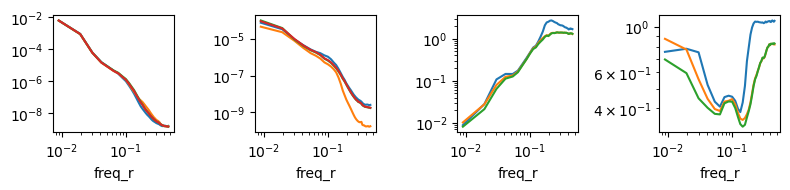

In [11]:
# Basic plot: 
plt.figure(figsize=(8, 2))

    
plt.subplot(141)
PSD_bm_true.mean('sample').plot()
PSD_bm_mse.mean(['sample']).plot()
PSD_bm_ssh.mean(['sample','stochastic_sample']).plot()
PSD_bm_sst_ssh.mean(['sample','stochastic_sample']).plot()

plt.xscale('log')
plt.yscale('log')

plt.subplot(142)
PSD_ubm_true.mean('sample').plot()
PSD_ubm_mse.mean(['sample']).plot()
PSD_ubm_ssh.mean(['sample','stochastic_sample']).plot()
PSD_ubm_sst_ssh.mean(['sample','stochastic_sample']).plot()

plt.xscale('log')
plt.yscale('log')

plt.subplot(143)
ESR_bm_mse.plot()
ESR_bm_ssh.plot()
ESR_bm_sst_ssh.plot()

plt.xscale('log')
plt.yscale('log')

plt.subplot(144)
ESR_ubm_mse.plot()
ESR_ubm_ssh.plot()
ESR_ubm_sst_ssh.plot()

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

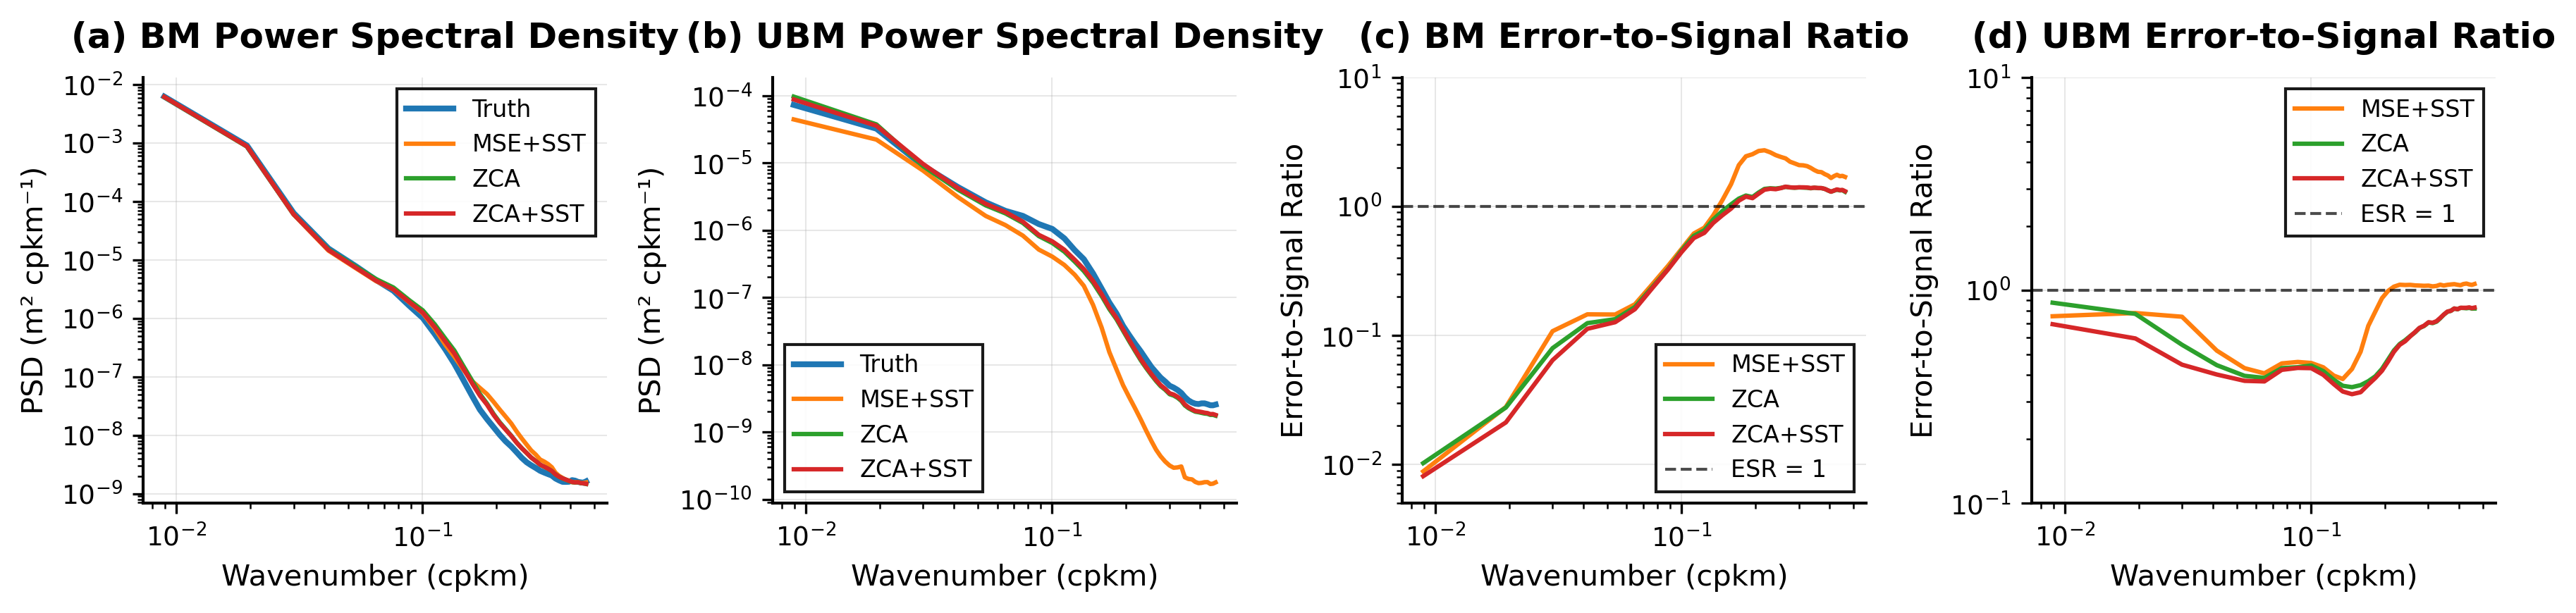

In [12]:
# From Claude: 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set publication-quality parameters
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 10
rcParams['axes.linewidth'] = 1.0
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 8
rcParams['figure.dpi'] = 300

# Define colors consistent with your paper's style
colors = {
    'true': '#1f77b4',      # Blue for truth
    'mse': '#ff7f0e',       # Orange for MSE baseline
    'zca': '#2ca02c',       # Green for ZCA 
    'zca_sst': '#d62728'    # Red for ZCA+SST
}

# Create figure with proper sizing for publication
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.subplots_adjust(wspace=0.3)

# Panel A: BM Power Spectral Density
ax1 = axes[0]
# Plot your data (replace with actual data calls)
PSD_bm_true.mean('sample').plot(ax=ax1, color=colors['true'], linewidth=2, label='Truth')
PSD_bm_mse.mean(['sample']).plot(ax=ax1, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_bm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_bm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Wavenumber (cpkm)', fontweight='normal')
ax1.set_ylabel('PSD (m² cpkm⁻¹)', fontweight='normal')
ax1.set_title('(a) BM Power Spectral Density', fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, linewidth=0.5)
ax1.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.9)

# Panel B: UBM Power Spectral Density  
ax2 = axes[1]
PSD_ubm_true.mean('sample').plot(ax=ax2, color=colors['true'], linewidth=2, label='Truth')
PSD_ubm_mse.mean(['sample']).plot(ax=ax2, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_ubm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_ubm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber (cpkm)', fontweight='normal')
ax2.set_ylabel('PSD (m² cpkm⁻¹)', fontweight='normal')
ax2.set_title('(b) UBM Power Spectral Density', fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, linewidth=0.5)
ax2.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.9)

# Panel C: BM Error-to-Signal Ratio
ax3 = axes[2]
ESR_bm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.5, label='MSE+SST')
ESR_bm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.5, label='ZCA')
ESR_bm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

# Add ESR = 1 reference line
ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber (cpkm)', fontweight='normal')
ax3.set_ylabel('Error-to-Signal Ratio', fontweight='normal')
ax3.set_title('(c) BM Error-to-Signal Ratio', fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3, linewidth=0.5)
ax3.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.9)

# Panel D: UBM Error-to-Signal Ratio
ax4 = axes[3]
ESR_ubm_mse.plot(ax=ax4, color=colors['mse'], linewidth=1.5, label='MSE+SST')
ESR_ubm_ssh.plot(ax=ax4, color=colors['zca'], linewidth=1.5, label='ZCA')
ESR_ubm_sst_ssh.plot(ax=ax4, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

# Add ESR = 1 reference line
ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber (cpkm)', fontweight='normal')
ax4.set_ylabel('Error-to-Signal Ratio', fontweight='normal')
ax4.set_title('(d) UBM Error-to-Signal Ratio', fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, linewidth=0.5)
ax4.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.9)

# Ensure consistent y-limits if needed (uncomment and adjust as necessary)
ax3.set_ylim([0.005, 10])
ax4.set_ylim([0.1, 10])

# Add overall figure improvements
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()

# Save with high quality settings
#plt.savefig('figure_psd_esr_comparison.pdf', dpi=300, bbox_inches='tight', 
#            facecolor='white', edgecolor='none')
plt.savefig('figure_psd_esr_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

#plt.show()

# Optional: Create a separate larger version for presentations
#fig_large, axes_large = plt.subplots(2, 2, figsize=(10, 8))
#fig_large.subplots_adjust(hspace=0.3, wspace=0.3)

# Repeat the plotting with larger axes (code structure same as above)
# This version provides more space for each panel if needed for talks/posters

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


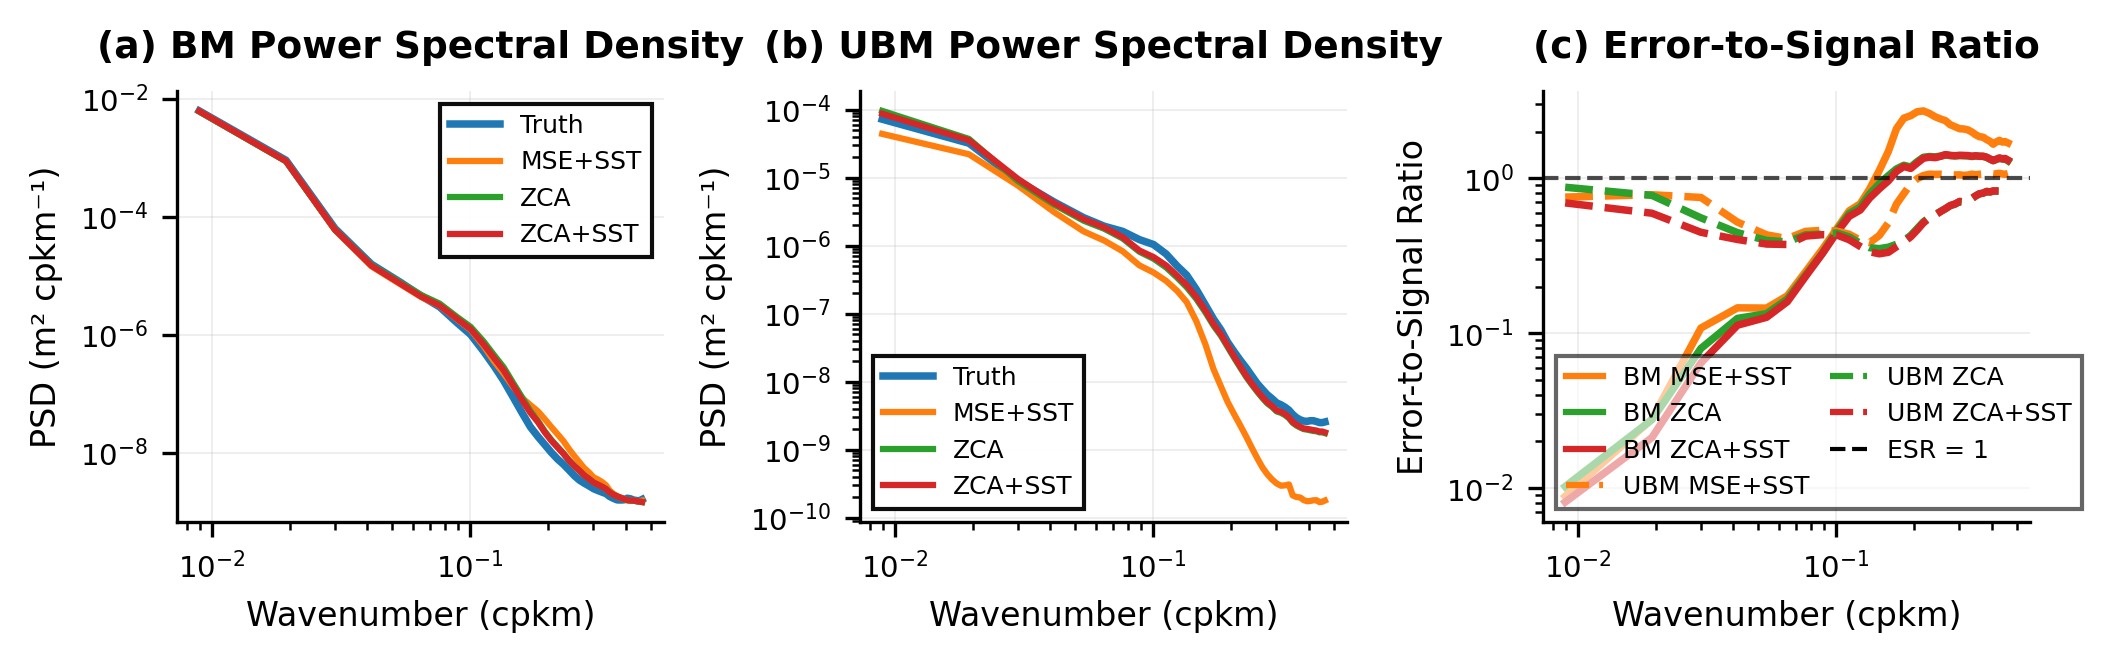

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set publication-quality parameters - MATCHING the 5-panel figure
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 8          # Matching the 5-panel figure
rcParams['axes.linewidth'] = 0.8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['axes.titlesize'] = 9
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

# Define colors consistent with your paper's style - SAME as before
colors = {
    'true': '#1f77b4',      # Blue for truth
    'mse': '#ff7f0e',       # Orange for MSE baseline
    'zca': '#2ca02c',       # Green for ZCA 
    'zca_sst': '#d62728'    # Red for ZCA+SST
}

# Create figure with 3 panels - MATCHING dimensions for compatibility
fig, axes = plt.subplots(1, 3, figsize=(7, 2.25))  # Compatible height with 5-panel figure
fig.subplots_adjust(wspace=0.35, left=0.08, right=0.98, top=0.85, bottom=0.18)

# Panel A: BM Power Spectral Density
ax1 = axes[0]
# Plot your data (replace with actual data calls)
PSD_bm_true.mean('sample').plot(ax=ax1, color=colors['true'], linewidth=1.8, label='Truth')
PSD_bm_mse.mean(['sample']).plot(ax=ax1, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_bm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_bm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Wavenumber (cpkm)')
ax1.set_ylabel('PSD (m² cpkm⁻¹)')
ax1.set_title('(a) BM Power Spectral Density', fontweight='bold', pad=8)
ax1.grid(True, alpha=0.25, linewidth=0.4)  # Lighter grid to match
ax1.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.95, fontsize=6)

# Panel B: UBM Power Spectral Density  
ax2 = axes[1]
PSD_ubm_true.mean('sample').plot(ax=ax2, color=colors['true'], linewidth=1.8, label='Truth')
PSD_ubm_mse.mean(['sample']).plot(ax=ax2, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_ubm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_ubm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber (cpkm)')
ax2.set_ylabel('PSD (m² cpkm⁻¹)')
ax2.set_title('(b) UBM Power Spectral Density', fontweight='bold', pad=8)
ax2.grid(True, alpha=0.25, linewidth=0.4)  # Lighter grid to match
ax2.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.95, fontsize=6)

# Panel C: Combined BM and UBM Error-to-Signal Ratio
ax3 = axes[2]

# Plot BM ESR (solid lines) - matching line weights
ESR_bm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.8, linestyle='-', label='BM MSE+SST')
ESR_bm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.8, linestyle='-', label='BM ZCA')
ESR_bm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.8, linestyle='-', label='BM ZCA+SST')

# Plot UBM ESR (dashed lines) 
ESR_ubm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.8, linestyle='--', label='UBM MSE+SST')
ESR_ubm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.8, linestyle='--', label='UBM ZCA')
ESR_ubm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.8, linestyle='--', label='UBM ZCA+SST')

# Add ESR = 1 reference line - matching style
ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('Error-to-Signal Ratio')
ax3.set_title('(c) Error-to-Signal Ratio', fontweight='bold', pad=8)
ax3.grid(True, alpha=0.25, linewidth=0.4)  # Lighter grid to match

# Create custom legend for combined ESR plot - more compact
legend_elements = [
    # BM lines (solid)
    plt.Line2D([0], [0], color=colors['mse'], linewidth=1.5, linestyle='-', label='BM MSE+SST'),
    plt.Line2D([0], [0], color=colors['zca'], linewidth=1.5, linestyle='-', label='BM ZCA'),
    plt.Line2D([0], [0], color=colors['zca_sst'], linewidth=1.5, linestyle='-', label='BM ZCA+SST'),
    # UBM lines (dashed)
    plt.Line2D([0], [0], color=colors['mse'], linewidth=1.5, linestyle='--', label='UBM MSE+SST'),
    plt.Line2D([0], [0], color=colors['zca'], linewidth=1.5, linestyle='--', label='UBM ZCA'),
    plt.Line2D([0], [0], color=colors['zca_sst'], linewidth=1.5, linestyle='--', label='UBM ZCA+SST'),
    # Reference line
    plt.Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='ESR = 1')
]

ax3.legend(handles=legend_elements, frameon=True, fancybox=False, edgecolor='black', 
          framealpha=0.6, ncol=2, fontsize=6, handlelength=1.5, columnspacing=0.8)

# Add overall figure improvements - MATCHING spine thickness
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)  # Match 5-panel figure
    ax.spines['bottom'].set_linewidth(0.8)  # Match 5-panel figure

plt.tight_layout()

# Save with high quality settings - MATCHING the 5-panel naming convention
plt.savefig('figures/figure_3panel_overall_performance.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)
plt.savefig('figures/figure_3panel_overall_performance.eps', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)
plt.savefig('figures/figure_3panel_overall_performance.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)

plt.show()

# print("✓ Compatible 3-panel figure (a-c) saved in PDF, EPS, and PNG formats")
# print(f"✓ Figure dimensions: {fig.get_size_inches()[0]:.1f} × {fig.get_size_inches()[1]:.1f} inches")
# print("✓ Styled to match the 5-panel figure (d-h)")
# print("✓ Ready for combination into 8-panel publication figure")